In [43]:
import json

import numpy as np
import openslide
import shapely.geometry as geometry
import rasterio.features as features

import tifffile
from tifffile import TiffWriter


In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(
            np.asarray(img), interpolation="none", cmap="gray", vmin=0, vmax=1
        )
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [12]:
#base_path: str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-QuPathProjekt-RCC(1Case)-10062021/"
# base_path: str = "/media/sciobiome/DATA/sklein_tmp/Scans-QuPathProjekt-RCC-1Case-10062021/"
base_path:str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/"

case: str = "RCC-TA-011.001.023~M" # 1.8 gb
#case: str = "RCC-TA-070.016~H" # 3.5 gb
# case: str = "RCC-TA-070.019~E" # 27 gb
cases: list[str] = ["RCC-TA-011.001.023~M", "RCC-TA-070.016~H", "RCC-TA-070.019~E"]

image = base_path + case + ".svs"

# JSON array like this [{type: ..., id: ..., geometry: ..., properties: ...}, {...}, ...]
geojson_array: str = base_path + case + ".svs.json"

# QuPath's FeatureCollection wraps the above in a dict
# {"type": "FeatureCollection", "features": [{...}, {...}, ...]}
geojson_feat: str = base_path + case + ".svs-FeatColl.json"

annos_of_interest: list[str] = [
    "Tumor_vital",
    "diffuse tumor growth in soft tissue",
    "Angioinvasion",
    "Tumor_necrosis",
    "Tumor_regression",
    "Tissue",
]


In [61]:
import numpy as np
from shapely.ops import split
# import geopandas
from shapely.geometry import MultiPolygon, Polygon, LineString


def get_squares_from_rect(RectangularPolygon, side_length=0.0025):
    """
    Divide a Rectangle (Shapely Polygon) into squares of equal area.

    `side_length` : required side of square

    """
    rect_coords = np.array(RectangularPolygon.boundary.coords.xy)
    y_list = rect_coords[1]
    x_list = rect_coords[0]
    y1 = min(y_list)
    y2 = max(y_list)
    x1 = min(x_list)
    x2 = max(x_list)
    width = x2 - x1
    height = y2 - y1

    xcells = int(np.round(width / side_length))
    ycells = int(np.round(height / side_length))

    yindices = np.linspace(y1, y2, ycells + 1)
    xindices = np.linspace(x1, x2, xcells + 1)
    horizontal_splitters = [
        LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
    ]
    vertical_splitters = [
        LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
    ]
    result = RectangularPolygon
    for splitter in vertical_splitters:
        result = MultiPolygon(split(result, splitter))
    for splitter in horizontal_splitters:
        result = MultiPolygon(split(result, splitter))
    square_polygons = list(result)

    return square_polygons

In [50]:
# 1. READ JSON ARRAY
input_file = open(geojson_array)
data = json.load(input_file)

# 2. FILTER ANNOTATIONS FOR TISSUE AND TUMOR

annos = []
for dict_like in data:
    props = dict_like["properties"]
    if props["objectType"] == "annotation":
        if props["classification"]["name"] in annos_of_interest:
            annos.append(dict_like)

# Open the SVS file
svs = openslide.open_slide(image)
width, height = svs.dimensions

# 3. CONVERT TO SHAPELY SHAPES
shapes = {
    annotation["properties"]["classification"]["name"]: geometry.shape(
        annotation["geometry"]
    )
    for annotation in annos
}

shapes["Tissue"].bounds

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

In [51]:
shapes["Tissue"].bounds

(5528.96, 4279.22, 97372.6, 93042.53)

In [42]:
# 1. READ JSON ARRAY
input_file = open(geojson_array)
data = json.load(input_file)

# 2. FILTER ANNOTATIONS FOR TISSUE AND TUMOR

annos = []
for dict_like in data:
    props = dict_like["properties"]
    if props["objectType"] == "annotation":
        if props["classification"]["name"] in annos_of_interest:
            annos.append(dict_like)

# Open the SVS file
svs = openslide.open_slide(image)
width, height = svs.dimensions

# 3. CONVERT TO SHAPELY SHAPES
shapes = {
    annotation["properties"]["classification"]["name"]: geometry.shape(
        annotation["geometry"]
    )
    for annotation in annos
}

# 4. CONVERT TO MASK (TUMOR AND TISSUE)
masks = {}
for case in cases:
    masks[case] = {}
    # masks[case+"_all-touched"] = {}
    for name, curr_shape in shapes.items():
        mask = features.rasterize(
            shapes=[curr_shape],
            out_shape=(
                height,
                width,
            ),  # this flip of dims seems necessary to get right shape
            dtype=np.uint8,
        )
        masks[case][name] = mask

    # for name, curr_shape in shapes.items():
    #     mask = features.rasterize(
    #         [curr_shape],
    #         out_shape=(
    #             height,
    #             width,
    #         ),  # this flip of dims seems necessary to get right shape
    #         all_touched=True,
    #     )
    #     masks[case+"_all-touched"][name] = mask


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

KeyboardInterrupt: 

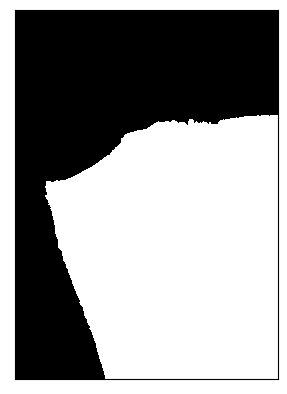

In [ ]:
# show(torch.as_tensor(masks[case][name]))

In [ ]:
# for name, curr_shape in shapes.items():
#     print((masks[case][name]==masks[case+"_all-touched"][name]).all())

In [ ]:
# curr_mask = masks[case].get("Tissue")
# print(f"""
# {np.histogram(curr_mask)}
# {curr_mask.shape}
# {np.mean(curr_mask)}
# """)


In [1]:
for case in cases:
    data_array = torch.as_tensor(masks[case]['Tissue'])
    # We need pickle protocol 4 or higher
    torch.save(data_array, case+'-Tissue.pt', pickle_protocol=5)


NameError: name 'cases' is not defined

In [10]:
from rasterio import features
from shapely import geometry
import openslide
import json

def geojson_to_mask(gjson_file, target_annos: list[str]):
    """
    gjson_file: path to geojson file
    target_annos: list of annotations to extract
    img_hxw: tuple of image dimensions (width, height)
    """

    # 1. READ JSON ARRAY from geojson file
    input_file = open(gjson_file)
    data = json.load(input_file)

    # 2. FILTER ANNOTATIONS FOR TISSUE AND TUMOR
    annos = []
    for dict_like in data:
        props = dict_like["properties"]
        if props["objectType"] == "annotation":
            if props["classification"]["name"] in target_annos:
                annos.append(dict_like)

    # 3. CONVERT TO SHAPELY SHAPES
    shapes = {
        annotation["properties"]["classification"]["name"]: geometry.shape(
            annotation["geometry"]
        )
        for annotation in annos
    }

    return shapes

In [14]:
from shapely.ops import unary_union, polygonize, linemerge
from shapely.geometry import LineString
import numpy as np

import os
import sys
from glob import glob

# compat
sys.path.append("../src/")

from helpers import show

img_path = "/home/sean/Documents/RCC-Data/Scans-QuPathProjekt-RCC(1Case)-10062021/RCC-TA-011.001.023~M.svs"
gjson =  geojson_array # img_path + ".json"
shapes = geojson_to_mask(gjson, ["Tissue"])


In [15]:
def get_squares_from_rect_faster(RectangularPolygon, side_length=0.0025):
    rect_coords = np.array(RectangularPolygon.boundary.coords.xy)
    y_list = rect_coords[1]
    x_list = rect_coords[0]
    y1 = min(y_list)
    y2 = max(y_list)
    x1 = min(x_list)
    x2 = max(x_list)
    width = x2 - x1
    height = y2 - y1

    # xcells = int(np.round(width / side_length))
    # ycells = int(np.round(height / side_length))
    # yindices = np.linspace(y1, y2, ycells + 1)
    # xindices = np.linspace(x1, x2, xcells + 1)

    # this might slightly overstep the shape
    yindices = np.arange(y1, y2, step=side_length)
    xindices = np.arange(x1, x2, step=side_length)

    horizontal_splitters = [
        LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
    ]
    vertical_splitters = [
        LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
    ]

    lines = horizontal_splitters + vertical_splitters
    lines.append(RectangularPolygon.boundary)
    lines = unary_union(lines)
    lines = linemerge(lines)

    # print(lines)
    return list(polygonize(lines))

In [16]:
def extract_poly_coords(geom):
    # https://stackoverflow.com/a/21922058
    if geom.geom_type == 'Polygon':
        exterior_coords = geom.exterior.coords[:]
        interior_coords = []
        for interior in geom.interiors:
            interior_coords += interior.coords[:]
    elif geom.geom_type == 'MultiPolygon':
        exterior_coords = []
        interior_coords = []
        for part in geom:
            epc = extract_poly_coords(part)  # Recursive call
            exterior_coords += epc['exterior_coords']
            interior_coords += epc['interior_coords']
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.type))
    return {'exterior_coords': exterior_coords,
            'interior_coords': interior_coords}



In [18]:
from shapely.prepared import prep
from shapely.geometry import Point

def get_grid_locations(polygon) -> list[Point]:
    # https://stackoverflow.com/a/66017009
    valid_points = []

    # determine maximum edges
    # polygon = max(shapes["Tissue"].geoms, key=lambda a: a.area)
    latmin, lonmin, latmax, lonmax = polygon.bounds
    step_size = 512

    # create prepared polygon
    prep_polygon = prep(polygon)

    # construct a rectangular mesh
    points = []
    for lat in np.arange(latmin, latmax, step_size):
        for lon in np.arange(lonmin, lonmax, step_size):
            # Cucim ignores sub-pixel precision
            # cutting decimals is faster than round and makes sure we dont have 1px gaps
            # points.append(Point((round(lat,4), round(lon,4))))
            points.append(Point((int(lat), int(lon))))

    # validate if each point falls inside shape using
    # the prepared polygon
    valid_points.extend(filter(prep_polygon.contains, points))

    return valid_points

In [19]:
valid_points =[]
for object in shapes["Tissue"].geoms:
    valid_points.extend(get_grid_locations(object))
    
valid_points2 = [point for geom in shapes["Tissue"].geoms for point in get_grid_locations(geom)  ]
sorted(valid_points2, key=lambda x: x.x) == sorted(valid_points, key=lambda x: x.x)

True

In [33]:
import shapely

isinstance(shapes["Tissue"].geoms[0], shapely.Polygon)

True

In [20]:
valid_points = get_grid_locations(max(shapes["Tissue"].geoms, key=lambda a: a.area))

In [21]:
from cucim import CuImage
import torch
from torchvision.utils import make_grid


img = CuImage(img_path)
region = img.read_region(size=(512, 512), location=((6040.96 - 512 / 2) , (22711.22 -512 / 2) ), level=0)
region2 = img.read_region(size=(512, 512), location=((6040.96 - 512 / 2) , (23223.22 -512 / 2) ), level=0)

show(make_grid([torch.einsum("hwc -> chw",torch.as_tensor(np.asarray(region))), torch.einsum("hwc -> chw",torch.as_tensor(np.asarray(region2)))], nrow=1))

region = img.read_region(size=(512, 512), location=((52632.96 - 512 / 2) , ( 4791.22 -512 / 2) ), level=0)
region2 = img.read_region(size=(512, 512), location=((53144.96 - 512 / 2) , ( 4791.22 -512 / 2) ), level=0)

show(make_grid([torch.einsum("hwc -> chw",torch.as_tensor(np.asarray(region))), torch.einsum("hwc -> chw",torch.as_tensor(np.asarray(region2)))], nrow=2))

# Points have coords x, y ==  width, height, same as CuImage
# sorted(valid_points, key=lambda pol: pol.y )


ValueError: Cannot open /home/sean/Documents/RCC-Data/Scans-QuPathProjekt-RCC(1Case)-10062021/RCC-TA-011.001.023~M.svs!

In [ ]:
result  =   []
for geometry_obj in list(shapes["Tissue"].geoms):
    # print(geometry_obj)
    result.append(extract_poly_coords(geometry_obj))

In [ ]:
biggest_poly = max(shapes["Tissue"].geoms, key=lambda a: a.area)
all_polys = sorted([a for a in shapes["Tissue"].geoms], reverse=True, key=lambda x: x.area)

tissues = [poly for poly in all_polys if poly.area > (biggest_poly.area // 2) ]


result = [(get_squares_from_rect_faster(Polygon(tissue_poly.exterior.coords), side_length=512)) for tissue_poly in tissues]

[<LINESTRING (5528.96 4279.22, 5528.96 92855.22)>, <LINESTRING (6040.96 4279.22, 6040.96 92855.22)>, <LINESTRING (6552.96 4279.22, 6552.96 92855.22)>, <LINESTRING (7064.96 4279.22, 7064.96 92855.22)>, <LINESTRING (7576.96 4279.22, 7576.96 92855.22)>, <LINESTRING (8088.96 4279.22, 8088.96 92855.22)>, <LINESTRING (8600.96 4279.22, 8600.96 92855.22)>, <LINESTRING (9112.96 4279.22, 9112.96 92855.22)>, <LINESTRING (9624.96 4279.22, 9624.96 92855.22)>, <LINESTRING (10136.96 4279.22, 10136.96 92855.22)>, <LINESTRING (10648.96 4279.22, 10648.96 92855.22)>, <LINESTRING (11160.96 4279.22, 11160.96 92855.22)>, <LINESTRING (11672.96 4279.22, 11672.96 92855.22)>, <LINESTRING (12184.96 4279.22, 12184.96 92855.22)>, <LINESTRING (12696.96 4279.22, 12696.96 92855.22)>, <LINESTRING (13208.96 4279.22, 13208.96 92855.22)>, <LINESTRING (13720.96 4279.22, 13720.96 92855.22)>, <LINESTRING (14232.96 4279.22, 14232.96 92855.22)>, <LINESTRING (14744.96 4279.22, 14744.96 92855.22)>, <LINESTRING (15256.96 4279.22

In [ ]:
[a.bounds for a in result[0][-20:]]
# TODO: check in qupath if this is roughly the last (bottom-right) pixel
# (97176.96, 74718.69704676491, 97228.93, 74927.84999999998)


[(96664.96, 88759.22, 97176.96, 89271.22),
 (96664.96, 89271.22, 97176.96, 89783.22),
 (96664.96, 89783.22, 97176.96, 90295.22),
 (96664.96, 90295.22, 97176.96, 90807.22),
 (96664.96, 90807.22, 97176.96, 91319.22),
 (96664.96, 91319.22, 97176.96, 91831.22),
 (96664.96, 91831.22, 97176.96, 92343.22),
 (96664.96, 92343.22, 97176.96, 92855.22),
 (96736.88, 69815.22, 97176.96, 70327.22),
 (96912.32008859358, 70327.22, 97176.96, 70839.22),
 (96941.89858097983, 74935.22, 97176.96, 75447.22),
 (97063.32, 70839.22, 97176.96, 71351.22),
 (97132.05, 74171.38, 97176.96, 74423.22),
 (97150.09411307055, 74423.22, 97176.96, 74587.62613504076),
 (97171.339606326, 71351.22, 97176.96, 71384.4702263582),
 (97173.275, 74927.84999999998, 97176.96, 74935.22),
 (97176.96, 71384.4702263582, 97372.6, 74171.38),
 (97176.96, 74587.62613504076, 97183.6, 74703.99551654287),
 (97168.79, 74703.99551654287, 97176.96, 74718.69704676491),
 (97176.96, 74718.69704676491, 97228.93, 74927.84999999998)]

In [ ]:
from shapely.geometry import Polygon

polygons = []
for polygon in list(shapes["Tissue"].geoms):
    print(polygon.bounds)
    polygon = extract_poly_coords(polygon)
    polygon, exterior = Polygon(polygon["exterior_coords"]), polygon["interior_coords"]
    print(polygon)
    polygons.append(get_squares_from_rect_faster(polygon, side_length=512))

(83523.28, 81899.02, 83830.42, 82017.16)
POLYGON ((83813.24 81899.02, 83796.06 81916.19, 83744.51 81916.19, 83727.33 81933.38, 83710.14 81933.38, 83675.78 81967.74, 83624.24 81967.74, 83607.06 81984.92, 83572.7 81984.92, 83555.51 82002.11, 83538.33 82002.11, 83523.28 82017.16, 83695.1 81995.69, 83830.42 81911.11, 83830.42 81899.02, 83813.24 81899.02))
[<LINESTRING (83523.28 81899.02, 83523.28 81899.02)>]
[<LINESTRING (83523.28 81899.02, 83523.28 81899.02)>]


ValueError: Cannot linemerge LINESTRING (83813.24 81899.02, 83796.06 81916.19, 83744.51 81916.19, 83727.33 81933.38, 83710.14 81933.38, 83675.78 81967.74, 83624.24 81967.74, 83607.06 81984.92, 83572.7 81984.92, 83555.51 82002.11, 83538.33 82002.11, 83523.28 82017.16, 83695.1 81995.69, 83830.42 81911.11, 83830.42 81899.02, 83813.24 81899.02)

In [ ]:
import pyvips

path = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M-Tissue.tif"
img = pyvips.Image.tiffload(path).crop(0,0, 412, 512)
shape = img.width, img.height
print(shape)
img.numpy().shape

(412, 512)


(512, 412)